In [102]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from helperFunctions import createDataSet, prepare_features_target
import os

In [103]:
year = 2018
file_num = -2
DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/train"
files = os.listdir(DATA_PATH)
file = files[file_num]
train_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file))
# Remove duplicates
train_set_list = [train_set_list[x] for x, _ in enumerate(train_set_list) if train_set_list[x].equals(train_set_list[x-1]) is False]
train_set = pd.concat(train_set_list)

DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/test"
files = os.listdir(DATA_PATH)
file = files[file_num]
test_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file), scaler=scaler)
# Remove duplicates
test_set_list = [test_set_list[x] for x, _ in enumerate(test_set_list) if test_set_list[x].equals(test_set_list[x-1]) is False]
test_set = pd.concat(test_set_list)

print(f"Length of train set: {len(train_set_list)}")
print(f"Length of test set: {len(test_set_list)}")
train_set_list[0]

Length of train set: 105
Length of test set: 14


,cbg,finger,carbInput,bolus,finger_extended,minutesAfterMeal,mealSize,minutesAfterBolus,bolusSize,cgm_rate_5min,cgm_rate_15min,glucose_lag_1,glucose_lag_2
0,232.0,269.0,60.0,8.2,269.0,0,60.0,0,8.2,-1.2,-2.000000,238.0,251.0
1,227.0,0.0,0.0,0.0,269.0,5,60.0,5,8.2,-1.0,-1.600000,232.0,238.0
2,228.0,0.0,0.0,0.0,269.0,10,60.0,10,8.2,0.2,-0.666667,227.0,232.0
3,238.0,0.0,0.0,0.0,269.0,15,60.0,15,8.2,2.0,0.400000,228.0,227.0
4,243.0,0.0,0.0,0.0,269.0,20,60.0,20,8.2,1.0,1.066667,238.0,228.0
5,236.0,0.0,0.0,0.0,269.0,25,60.0,25,8.2,-1.4,0.533333,243.0,238.0
6,231.0,0.0,0.0,0.0,269.0,30,60.0,30,8.2,-1.0,-0.466667,236.0,243.0
7,227.0,0.0,0.0,0.0,269.0,35,60.0,35,8.2,-0.8,-1.066667,231.0,236.0
8,225.0,0.0,0.0,0.0,269.0,40,60.0,40,8.2,-0.4,-0.733333,227.0,231.0
9,221.0,0.0,0.0,0.0,269.0,45,60.0,45,8.2,-0.8,-0.666667,225.0,227.0


In [104]:
data = train_set_list[0].cbg

In [105]:
def subsample_df(df, start=0, stop=-1, subsamples = 1):
    df = pd.concat([df[start:stop:subsamples], df.tail(1)])
    return df

subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=4)
subsampled_values.index.values
print(subsampled_values.index.values)
print(subsampled_values.values)

def reconstruct_samples(df, numOfValues, interpolation = "interp1d"):
    x = df.index.values
    y = df.values
    if interpolation == "interp1d":
        f = interpolate.interp1d(x, y)
    elif interpolation == "cubicspline":
        f = interpolate.CubicSpline(x, y)

    xnew = np.arange(x[0], x[-1]+1, numOfValues)
    ynew = f(xnew)
    return xnew, ynew

samples_reconstructed = reconstruct_samples(subsampled_values, 1, "cubicspline")
samples_reconstructed

[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 55]
[232. 243. 225. 216. 196. 169. 153. 138. 122. 121. 116. 122. 118. 112.
 129.]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]),
 array([232.        , 240.46840283, 244.55317466, 245.11135916,
        243.        , 239.07614084, 234.19682534, 229.21909717,
        225.        , 222.13328382, 220.15952398, 218.35600215,
        216.        , 212.51572387, 207.91507873, 202.35689423,
        196.        , 189.05382071, 181.93016109, 175.09142094,
        169.        , 163.98774331, 159.86427689, 156.30867203,
        153.        , 149.65145605, 146.11273133, 142.26764094,
        138.        , 133.31268247, 128.68479778, 124.7145142 ,
        122.        , 120.91031405, 120.89807754, 121.18680227,
        121.        , 119.81168633, 118.09789205, 116.58515174,
        116.        , 116.82731563, 118.58535428, 120.55071578,
        122.        , 122.36342614, 12

Text(0, 0.5, 'CBG [mg/dl]')

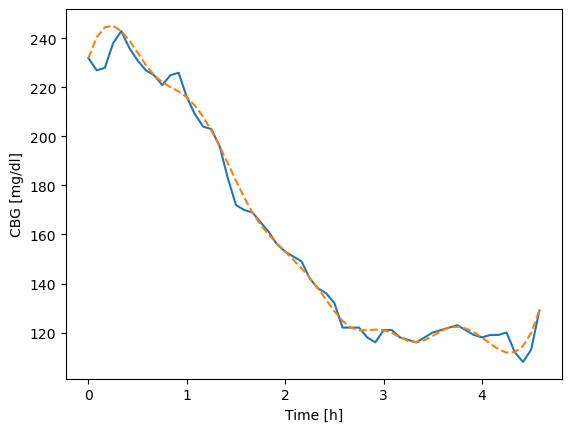

In [106]:
plt.plot(data.index.values*5/60, data)
plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
plt.xlabel("Time [h]")
plt.ylabel("CBG [mg/dl]")

In [107]:
def create_statistics(df, reconstruction):
    length = len(reconstruction) if len(df) > len(reconstruction) else len(df) 
    def construct_dict(data):
        dictionary = {"mean": np.mean(data), 
                      "std": np.std(data)}
        return dictionary
    mse = np.mean((df[:length].values - reconstruction[:length])**2)
    true_dict = construct_dict(df)
    reconstruct_dict = construct_dict(reconstruction)
    return mse, true_dict, reconstruct_dict

true_list = []
reconstructed_list = []

mse, true, reconstructed = create_statistics(data, samples_reconstructed[1])
true_list.append(true)
reconstructed_list.append(reconstructed)
print(mse, true_list, reconstructed_list)

19.446477239694666 [{'mean': 159.625, 'std': 45.405931999181405}] [{'mean': 160.56338565310378, 'std': 46.7877502323114}]


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_50523/3508076977.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


[{'mean': 159.625, 'std': 45.405931999181405}, {'mean': 120.60714285714286, 'std': 25.728443523121427}, {'mean': 179.46428571428572, 'std': 45.986008852737825}, {'mean': 213.14285714285714, 'std': 46.53049252580374}, {'mean': 243.96428571428572, 'std': 11.946255070275438}, {'mean': 226.82142857142858, 'std': 27.124124174706502}, {'mean': 124.69642857142857, 'std': 24.149031068152862}, {'mean': 141.58928571428572, 'std': 29.97009031977565}, {'mean': 200.125, 'std': 43.982570614473445}, {'mean': 147.375, 'std': 25.71170001880745}, {'mean': 114.91071428571429, 'std': 32.22758179046676}, {'mean': 189.33928571428572, 'std': 38.522385322282005}, {'mean': 158.5, 'std': 12.395275597696775}, {'mean': 154.64285714285714, 'std': 66.79537745218296}, {'mean': 203.76785714285714, 'std': 38.45915786883004}, {'mean': 142.71428571428572, 'std': 53.306631283317}, {'mean': 218.71428571428572, 'std': 55.476415286689395}, {'mean': 197.25, 'std': 53.16760896313791}, {'mean': 155.26785714285714, 'std': 78.45

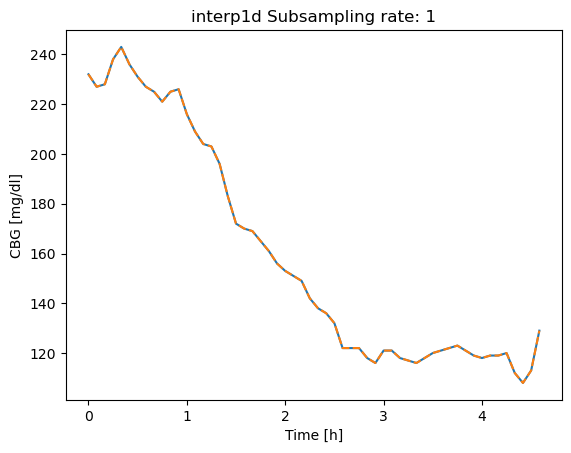

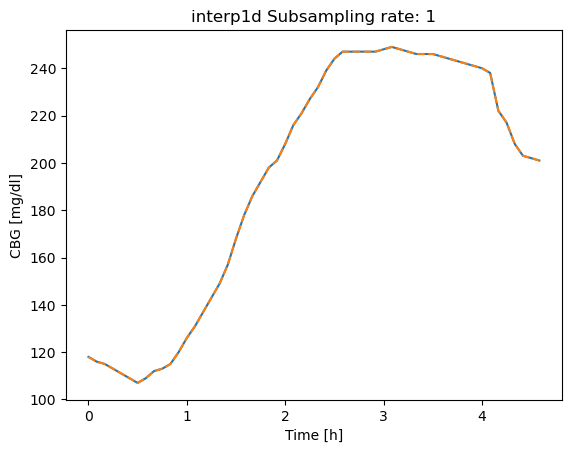

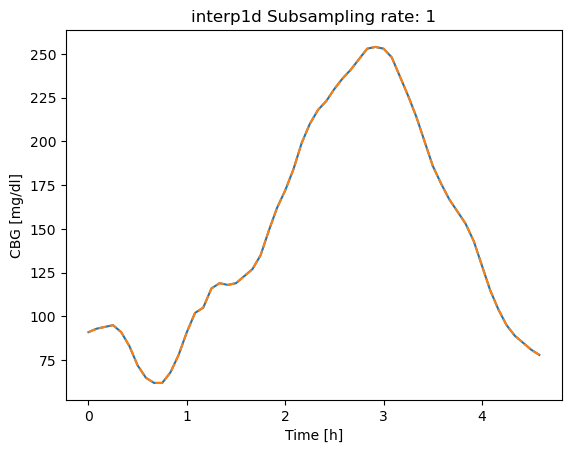

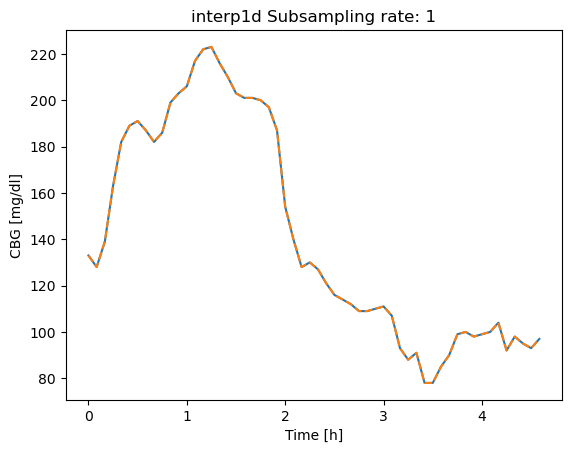

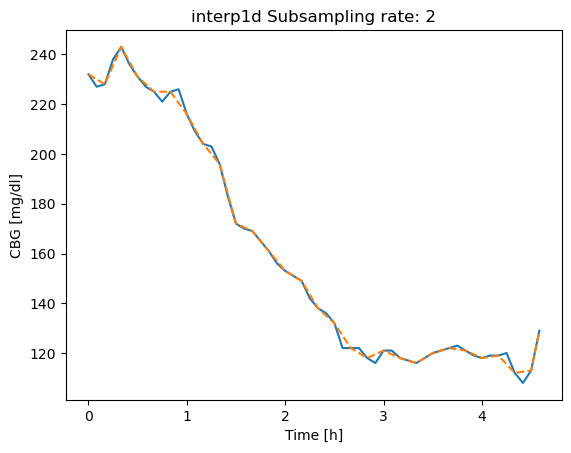

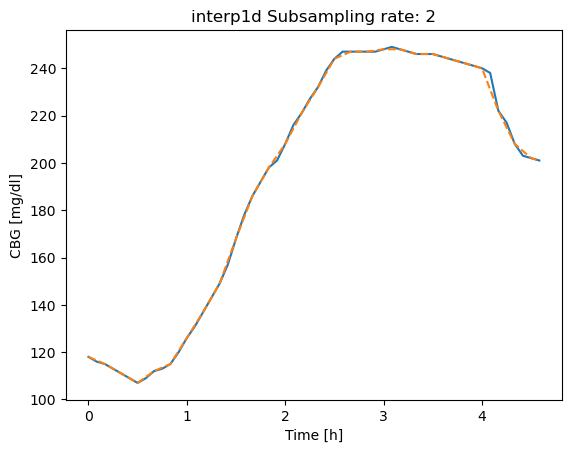

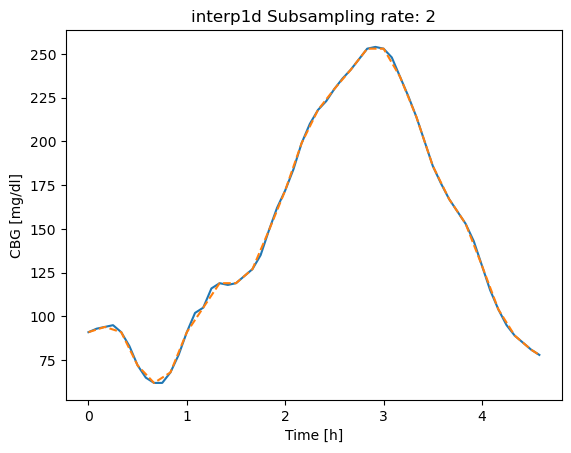

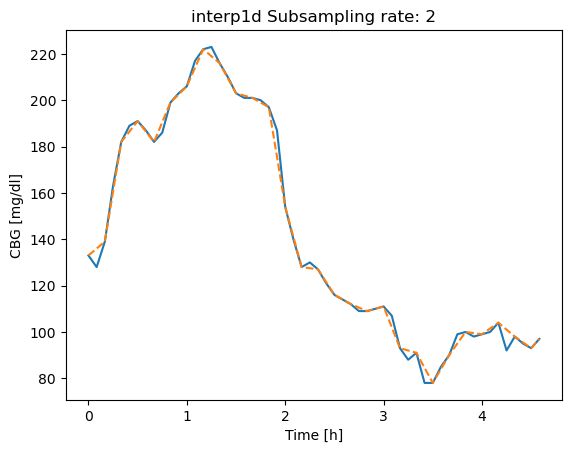

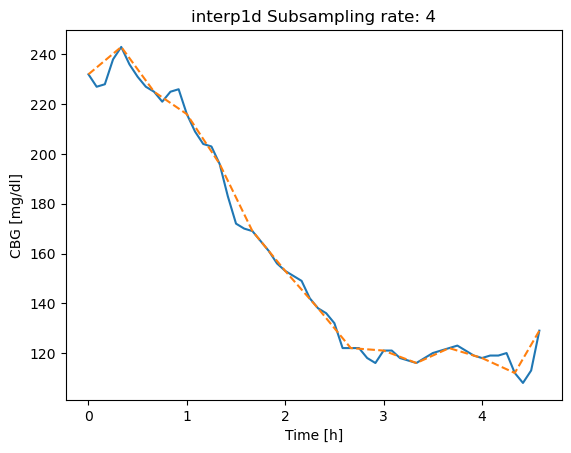

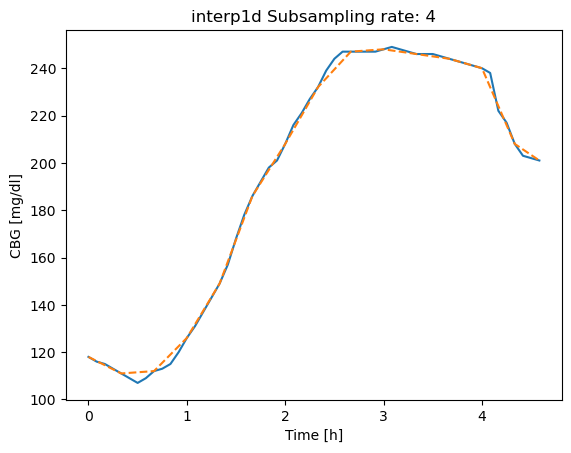

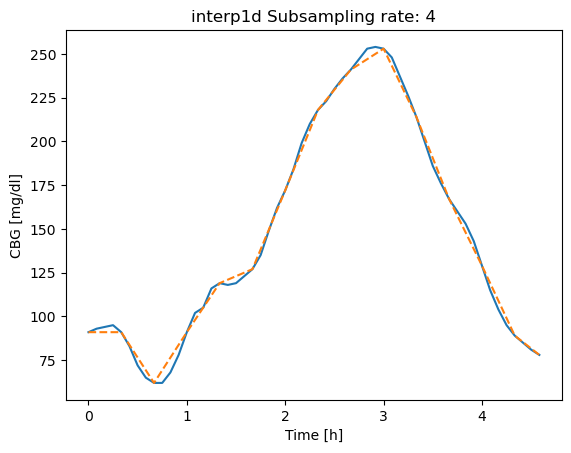

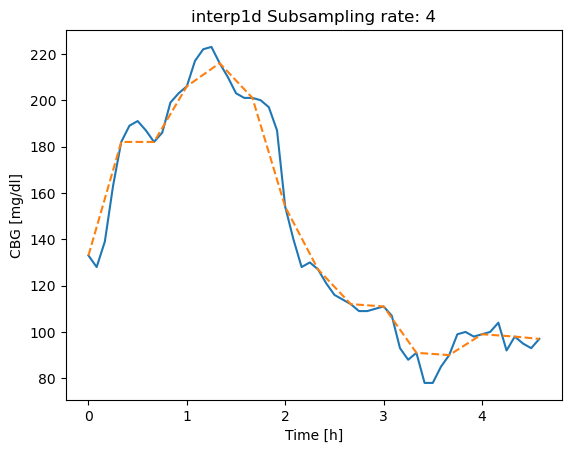

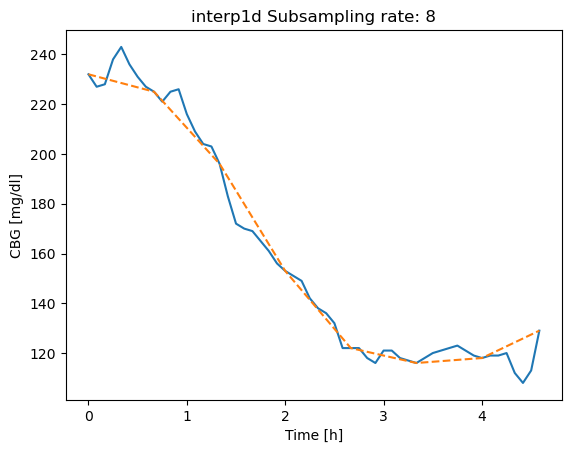

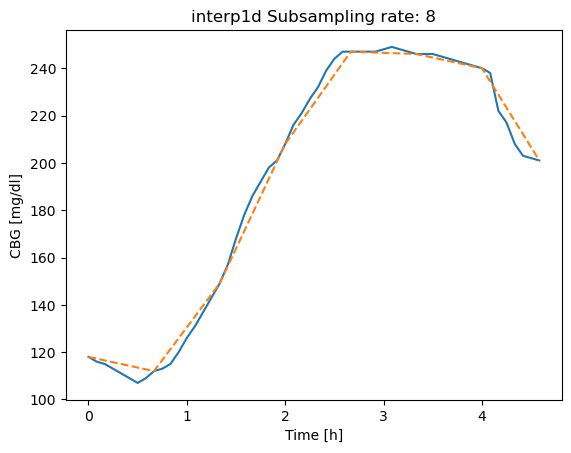

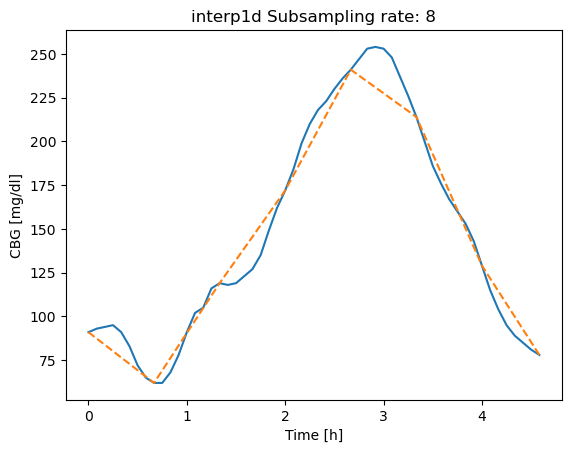

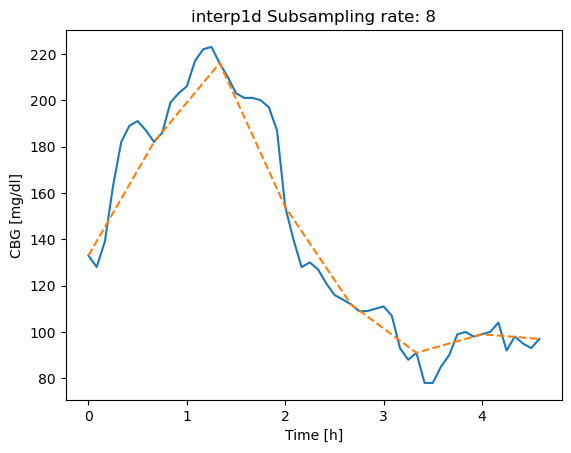

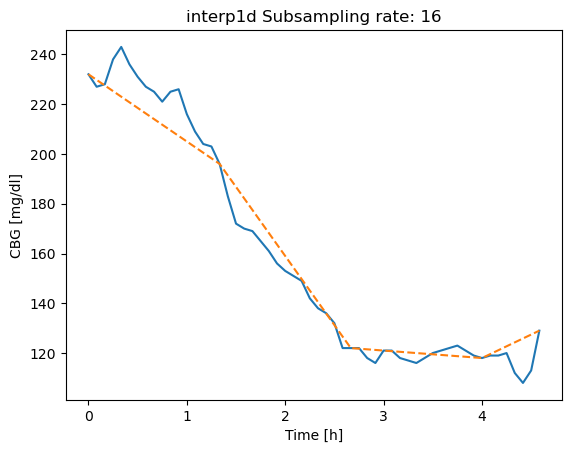

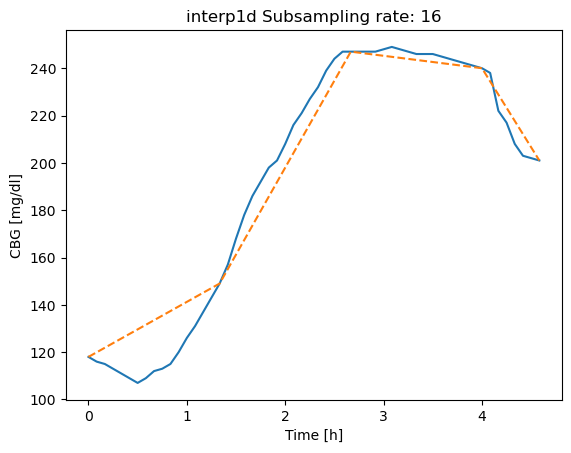

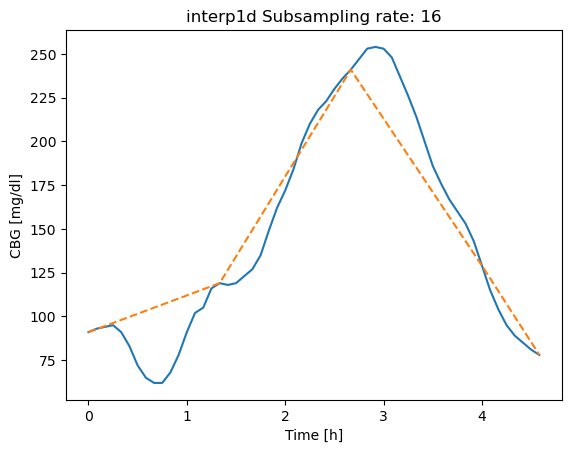

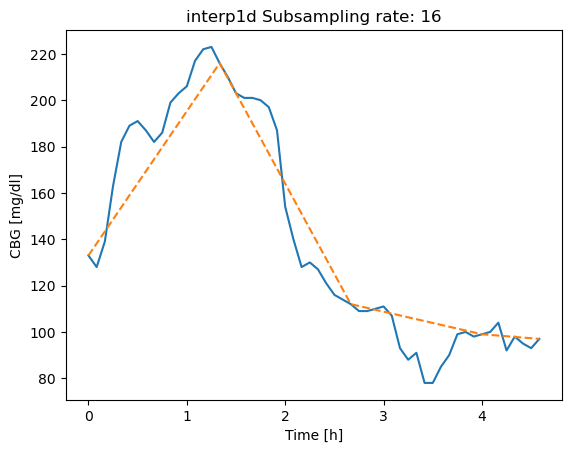

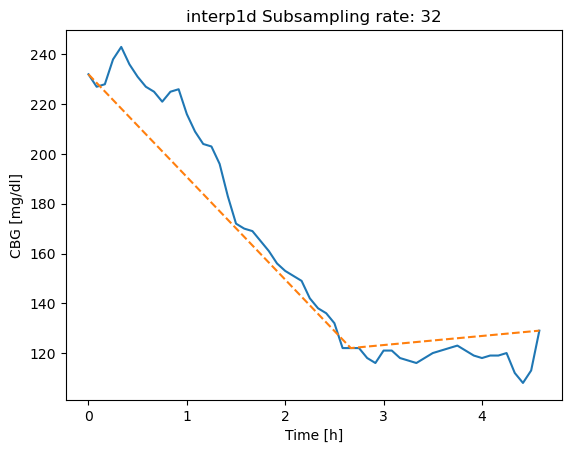

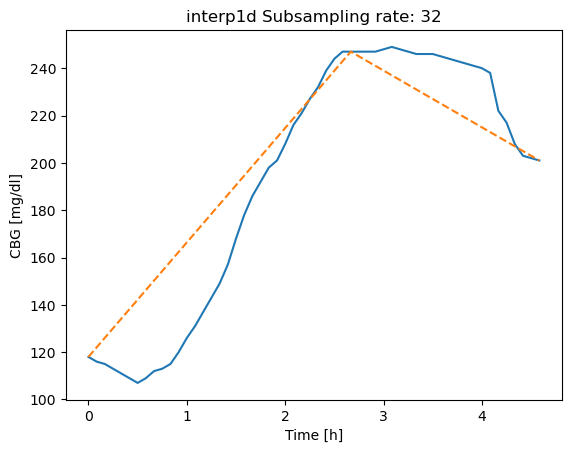

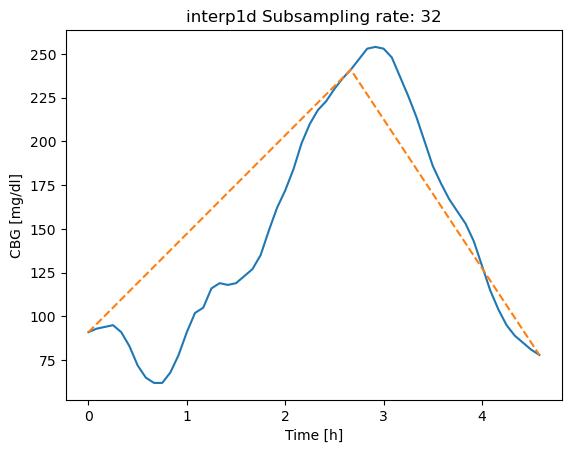

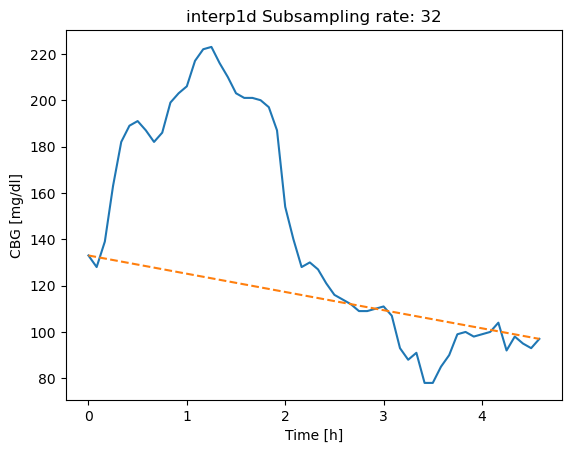

In [108]:
# Combining all functions:
subsampling = [1, 2, 4, 8, 16, 32]
true_list = []
reconstructed_list = []
mse_list = []
interpolation = "interp1d"

for sub in subsampling:
    for i, data in enumerate(train_set_list):
        data = data.cbg
        subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=sub)
        samples_reconstructed = reconstruct_samples(subsampled_values, 1, interpolation)

        if i % 30 == 0:
            plt.figure()
            plt.plot(data.index.values*5/60, data)
            plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
            plt.xlabel("Time [h]")
            plt.ylabel("CBG [mg/dl]")
            plt.title(f"{interpolation} Subsampling rate: {sub}")

        mse, true, reconstructed = create_statistics(data, samples_reconstructed[1])
        mse_list.append(mse)
        true_list.append(true)
        reconstructed_list.append(reconstructed)
print(true_list, reconstructed_list)



In [ ]:
def create_plots(mse_list, reconstructed_list, interpolation):
    mses = [[mse for mse in mse_list[105*i:(105*i)+105]]  for i in range(len(subsampling))]
    mses_subsampled_1 = mses[0]
    mses_subsampled_2 = mses[1]
    mses_subsampled_4 = mses[2]
    mses_subsampled_8 = mses[3]
    mses_subsampled_16 = mses[4]
    mses_subsampled_32 = mses[5]
    labels = ['True', 'Reconstructed']

    fig, ax = plt.subplots()
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel("Subsampling Rate")
    ax.set_title(interpolation)
    bplot = ax.boxplot([mses_subsampled_1,
                        mses_subsampled_2,
                        mses_subsampled_4,
                        mses_subsampled_8,
                        mses_subsampled_16,
                        mses_subsampled_32],
                        patch_artist=True,  # fill with color
                        )  # will be used to label x-ticks
    ax.set_xticks([y + 1 for y in range(len(subsampling))],
                    labels=subsampling)
    
    reconstructed_means = [[reconstructed['mean'] for reconstructed in reconstructed_list[105*i:(105*i)+105]]  for i in range(len(subsampling))]
    reconstructed_means_subsampled_1 = reconstructed_means[0]
    reconstructed_means_subsampled_2 = reconstructed_means[1]
    reconstructed_means_subsampled_4 = reconstructed_means[2]
    reconstructed_means_subsampled_8 = reconstructed_means[3]
    reconstructed_means_subsampled_16 = reconstructed_means[4]
    reconstructed_means_subsampled_32 = reconstructed_means[5]

    fig, ax = plt.subplots()
    ax.set_xlabel("Subsampling Rate")
    ax.set_ylabel('Mean CBG [mg/dl]')
    ax.set_title(interpolation)

    bplot = ax.boxplot([reconstructed_means_subsampled_1,
                        reconstructed_means_subsampled_2,
                        reconstructed_means_subsampled_4,
                        reconstructed_means_subsampled_8,
                        reconstructed_means_subsampled_16,
                        reconstructed_means_subsampled_32],
                        patch_artist=True,  # fill with color
                        )  # will be used to label x-ticks
    ax.set_xticks([y + 1 for y in range(len(subsampling))],
                    labels=subsampling)


    plt.show()


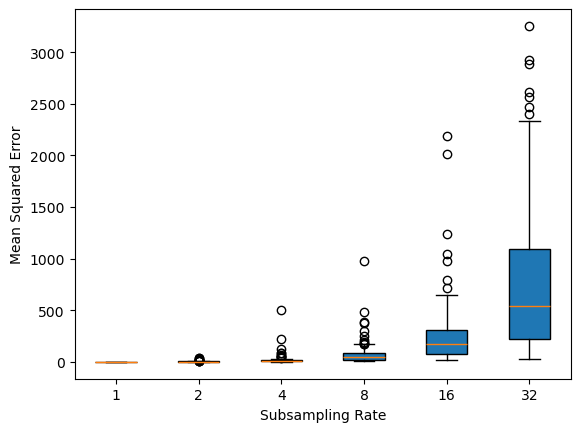

In [110]:
mses = [[mse for mse in mse_list[105*i:(105*i)+105]]  for i in range(len(subsampling))]
mses_subsampled_1 = mses[0]
mses_subsampled_2 = mses[1]
mses_subsampled_4 = mses[2]
mses_subsampled_8 = mses[3]
mses_subsampled_16 = mses[4]
mses_subsampled_32 = mses[5]
labels = ['True', 'Reconstructed']

fig, ax = plt.subplots()
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel("Subsampling Rate")
bplot = ax.boxplot([mses_subsampled_1,
                    mses_subsampled_2,
                    mses_subsampled_4,
                    mses_subsampled_8,
                    mses_subsampled_16,
                    mses_subsampled_32],
                    patch_artist=True,  # fill with color
                    )  # will be used to label x-ticks
ax.set_xticks([y + 1 for y in range(len(subsampling))],
                  labels=subsampling)

plt.show()

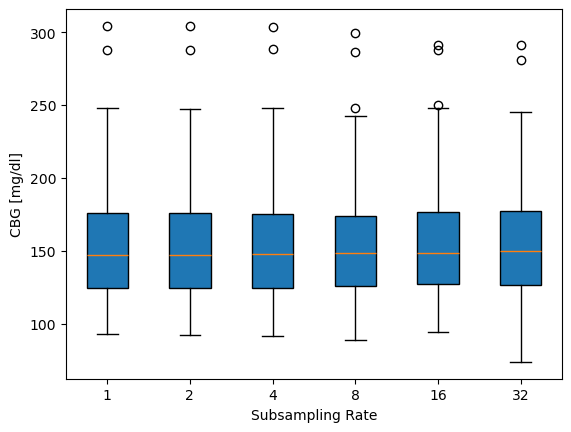

In [111]:
reconstructed_means = [[reconstructed['mean'] for reconstructed in reconstructed_list[105*i:(105*i)+105]]  for i in range(len(subsampling))]
reconstructed_means_subsampled_1 = reconstructed_means[0]
reconstructed_means_subsampled_2 = reconstructed_means[1]
reconstructed_means_subsampled_4 = reconstructed_means[2]
reconstructed_means_subsampled_8 = reconstructed_means[3]
reconstructed_means_subsampled_16 = reconstructed_means[4]
reconstructed_means_subsampled_32 = reconstructed_means[5]

fig, ax = plt.subplots()
ax.set_ylabel('CBG [mg/dl]')

bplot = ax.boxplot([reconstructed_means_subsampled_1,
                    reconstructed_means_subsampled_2,
                    reconstructed_means_subsampled_4,
                    reconstructed_means_subsampled_8,
                    reconstructed_means_subsampled_16,
                    reconstructed_means_subsampled_32],
                    patch_artist=True,  # fill with color
                    )  # will be used to label x-ticks
ax.set_xticks([y + 1 for y in range(len(subsampling))],
                  labels=subsampling)
ax.set_xlabel("Subsampling Rate")


plt.show()

[{'mean': 159.625, 'std': 45.405931999181405}, {'mean': 120.60714285714286, 'std': 25.728443523121427}, {'mean': 179.46428571428572, 'std': 45.986008852737825}, {'mean': 213.14285714285714, 'std': 46.53049252580374}, {'mean': 243.96428571428572, 'std': 11.946255070275438}, {'mean': 226.82142857142858, 'std': 27.124124174706502}, {'mean': 124.69642857142857, 'std': 24.149031068152862}, {'mean': 141.58928571428572, 'std': 29.97009031977565}, {'mean': 200.125, 'std': 43.982570614473445}, {'mean': 147.375, 'std': 25.71170001880745}, {'mean': 114.91071428571429, 'std': 32.22758179046676}, {'mean': 189.33928571428572, 'std': 38.522385322282005}, {'mean': 158.5, 'std': 12.395275597696775}, {'mean': 154.64285714285714, 'std': 66.79537745218296}, {'mean': 203.76785714285714, 'std': 38.45915786883004}, {'mean': 142.71428571428572, 'std': 53.306631283317}, {'mean': 218.71428571428572, 'std': 55.476415286689395}, {'mean': 197.25, 'std': 53.16760896313791}, {'mean': 155.26785714285714, 'std': 78.45

/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_50523/99551726.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


TypeError: create_plots() missing 1 required positional argument: 'interpolation'

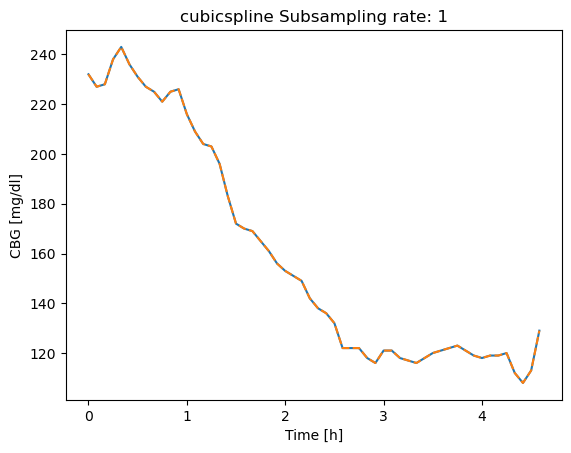

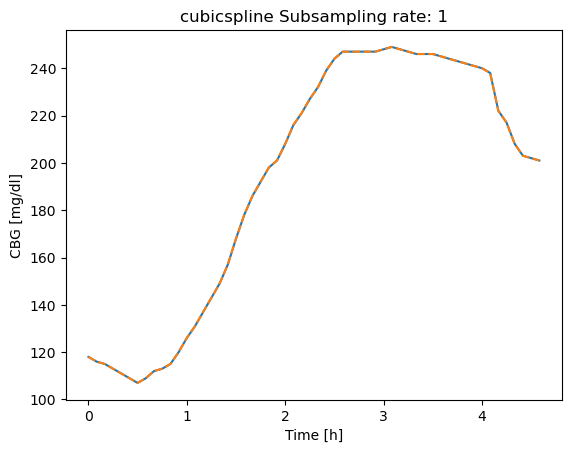

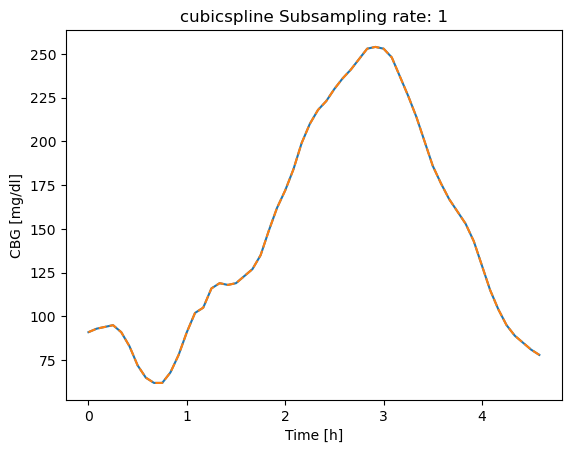

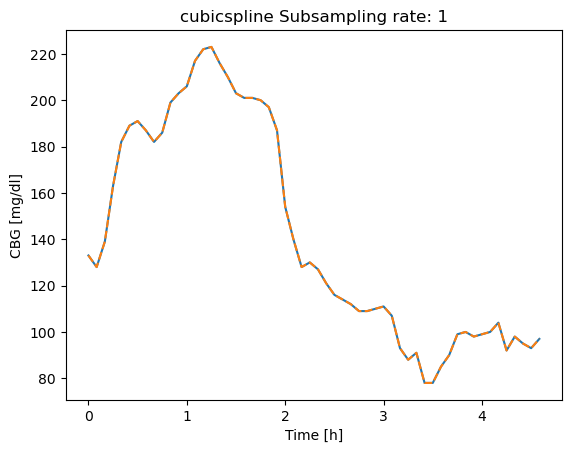

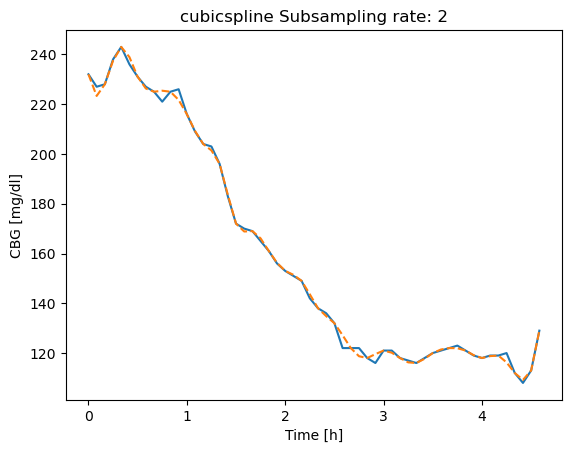

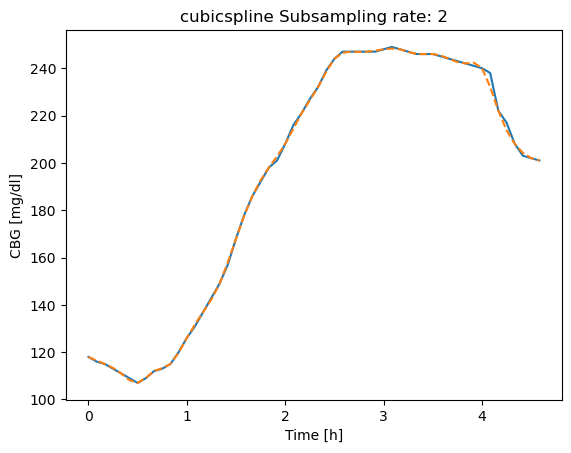

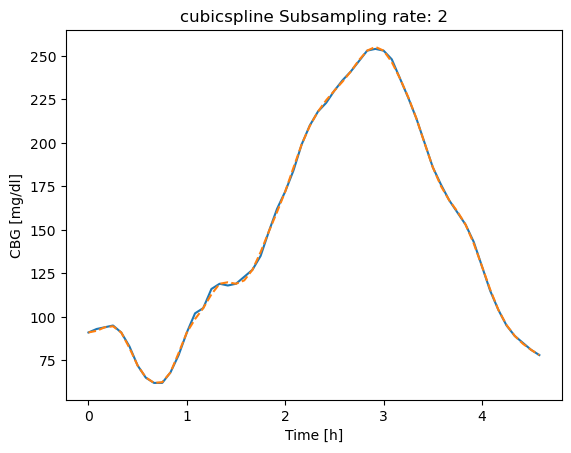

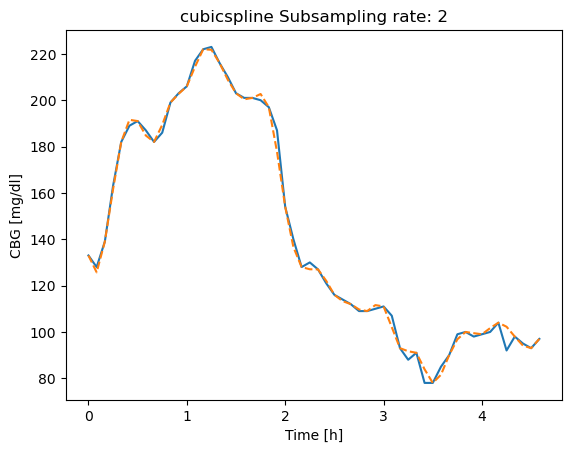

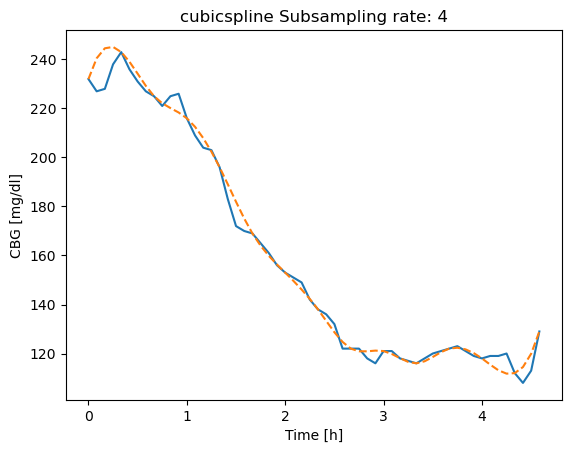

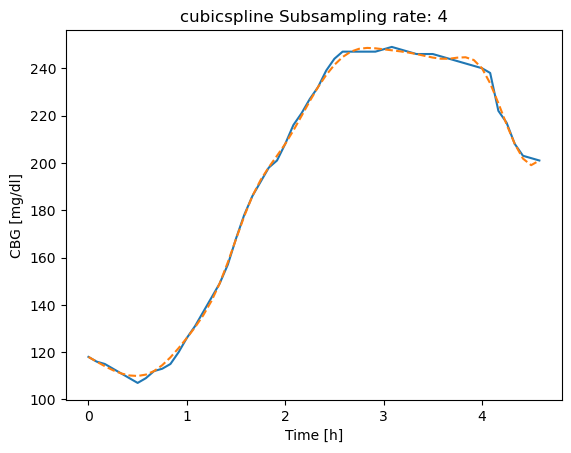

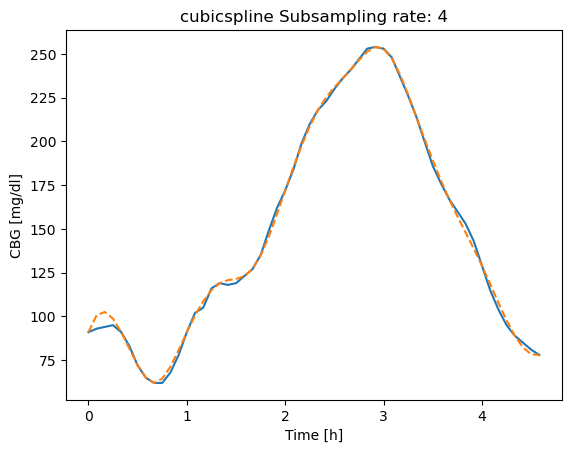

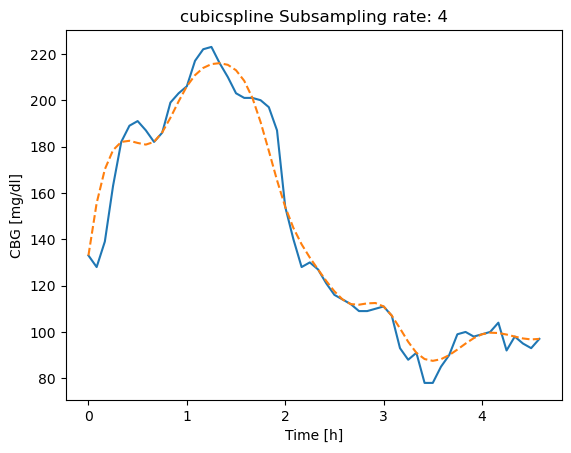

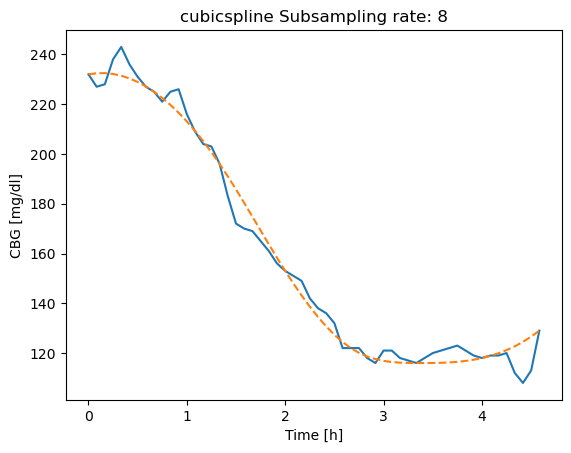

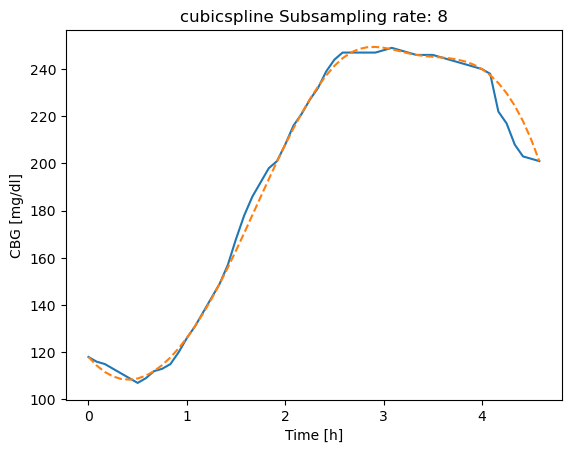

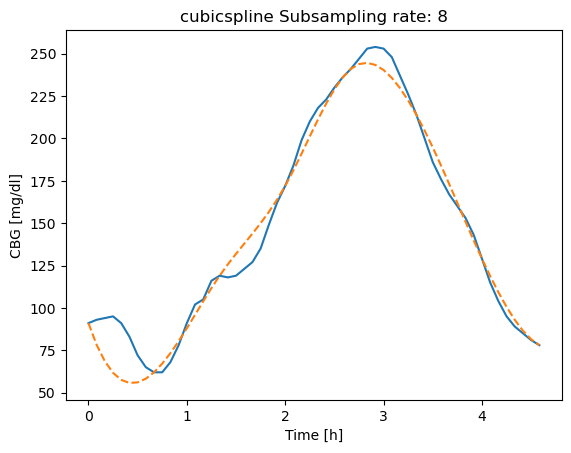

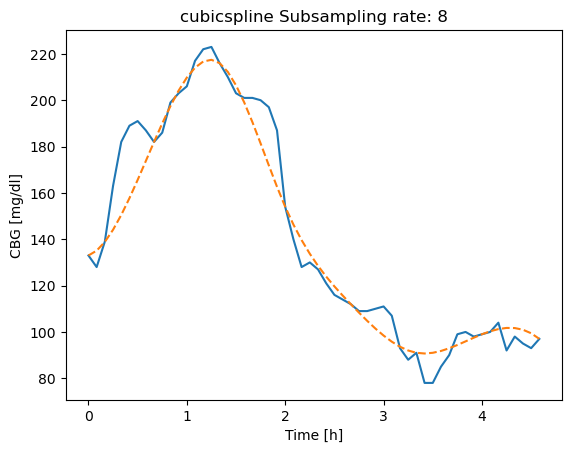

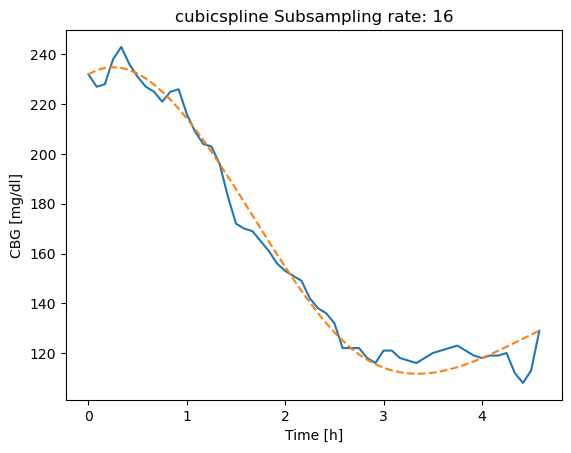

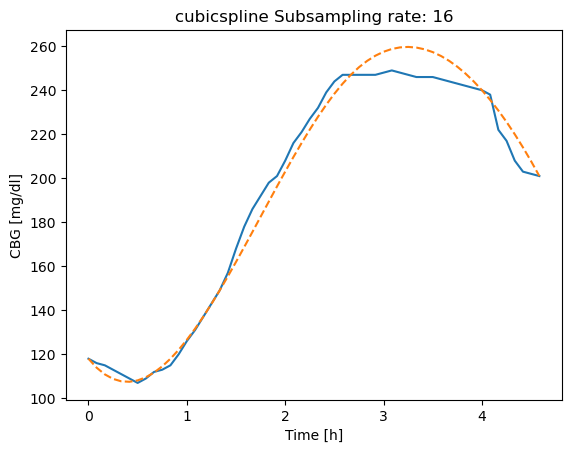

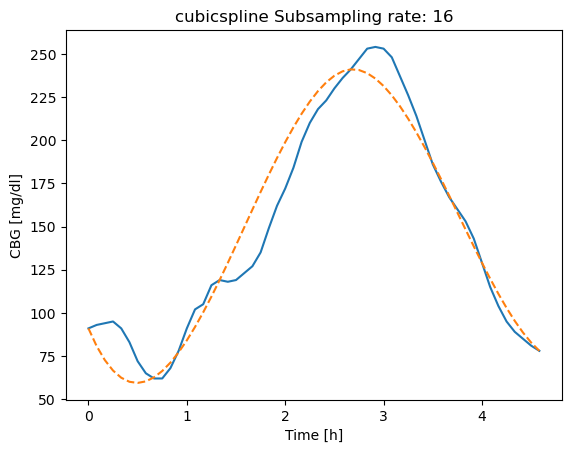

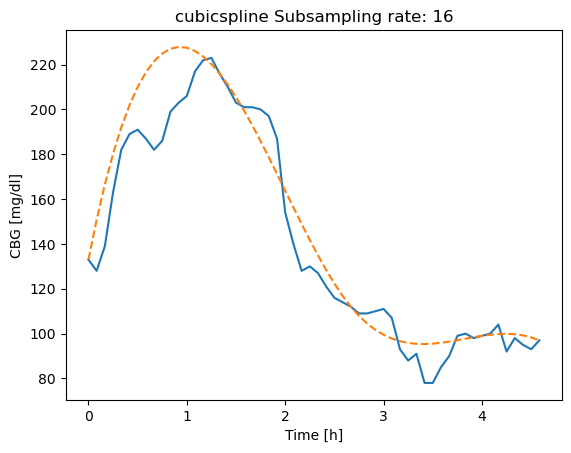

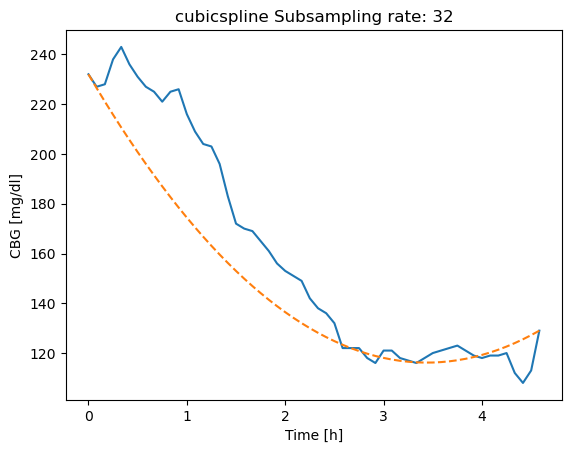

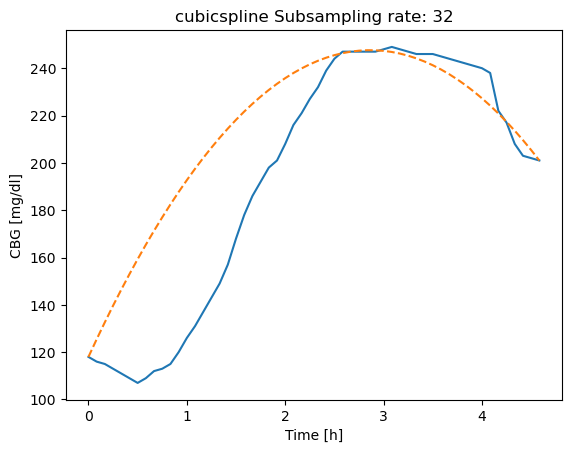

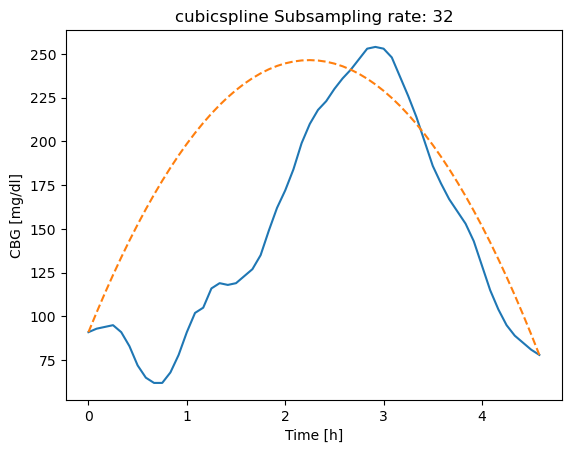

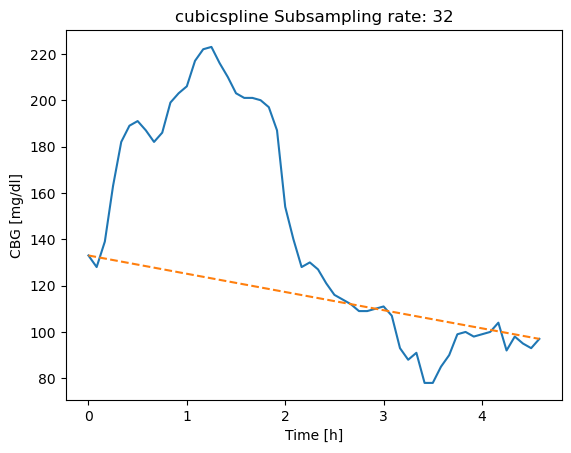

In [112]:
# Combining all functions:
subsampling = [1, 2, 4, 8, 16, 32]
true_list = []
reconstructed_list = []
mse_list = []
interpolation = "cubicspline"

for sub in subsampling:
    for i, data in enumerate(train_set_list):
        data = data.cbg
        subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=sub)
        samples_reconstructed = reconstruct_samples(subsampled_values, 1, interpolation)

        if i % 30 == 0:
            plt.figure()
            plt.plot(data.index.values*5/60, data)
            plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
            plt.xlabel("Time [h]")
            plt.ylabel("CBG [mg/dl]")
            plt.title(f"{interpolation} Subsampling rate: {sub}")

        mse, true, reconstructed = create_statistics(data, samples_reconstructed[1])
        mse_list.append(mse)
        true_list.append(true)
        reconstructed_list.append(reconstructed)
print(true_list, reconstructed_list)

create_plots(mse_list, reconstructed_list)